(222698, 2)


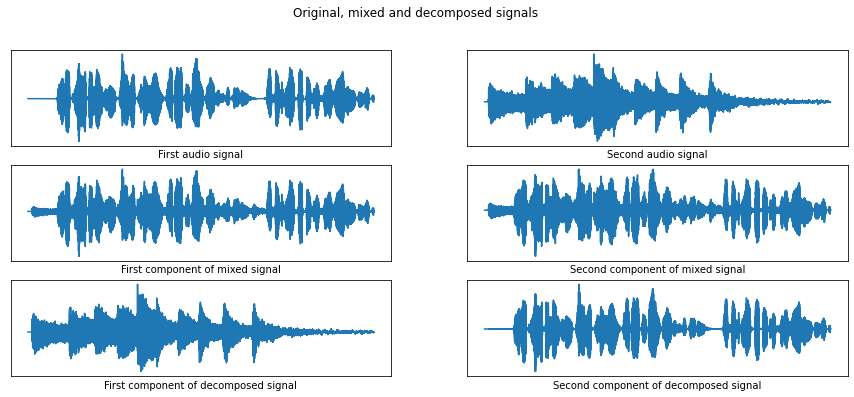

In [14]:
# ica_audio.py
# Author: Slim Essid
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import wave
from sklearn import decomposition
# -- Read audio data ----------------------------------------------------------
def wavread(filename):
    wf = wave.open(filename)
    s = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s

def wavwrite(filename, s, nchannels=1):
    wf = wave.open(filename,'wb')
    wf.setnchannels(nchannels)
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s/max(abs(s))*2**14 # normalise arbitrarily
    wf.writeframes(s.astype(np.int16).tobytes())
    wf.close()
    
s1 = wavread('./snd/es02.wav')
s2 = wavread('./snd/si01.wav')
# -- Create stereo mix ---------------------------------------------------------
nsmp = min(len(s1), len(s2))
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]
# Mixing matrix
A = np.array([ [0.6, 0.5],
[0.4, 0.5]
])
# Do the mix
X = S.dot(A)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(3,2,1)
ax.plot(s1)
ax.set_xlabel("First audio signal")
ax.set_xticklabels("")
ax.set_xticks([])
ax.set_yticklabels("")
ax.set_yticks([])
ax = fig.add_subplot(3,2,2)
ax.plot(s2)
ax.set_xlabel("Second audio signal")
ax.set_xticklabels("")
ax.set_xticks([])
ax.set_yticklabels("")
ax.set_yticks([])
ax = fig.add_subplot(3,2,3)
ax.plot(X[:,0])
ax.set_xlabel("First component of mixed signal")
ax.set_xticklabels("")
ax.set_xticks([])
ax.set_yticklabels("")
ax.set_yticks([])
ax = fig.add_subplot(3,2,4)
ax.plot(X[:,1])
ax.set_xlabel("Second component of mixed signal")
ax.set_xticklabels("")
ax.set_xticks([])
ax.set_yticklabels("")
ax.set_yticks([])
# Write mix file
x = np.zeros(2*nsmp)
x[::2] = X[:,0]
x[1::2] = X[:,1]
wavwrite('./snd/mix.wav', x, nchannels=2)
# -- ICA source separation -----------------------------------------------------
model = decomposition.FastICA(n_components = 2)
# Visualise sources
x_t = model.fit_transform(X)
print(x_t.shape)
# Write audio sources
ax = fig.add_subplot(3,2,5)
ax.plot(x_t[:,0])
ax.set_xlabel("First component of decomposed signal")
ax.set_xticklabels("")
ax.set_xticks([])
ax.set_yticklabels("")
ax.set_yticks([])
ax = fig.add_subplot(3,2,6)
ax.plot(x_t[:,1])
ax.set_xlabel("Second component of decomposed signal")
ax.set_xticklabels("")
ax.set_xticks([])
ax.set_yticklabels("")
ax.set_yticks([])
fig.patch.set_facecolor("white")
fig.suptitle("Original, mixed and decomposed signals")
plt.subplots_adjust()
plt.show()
wavwrite("./snd/cmp0.wav", x_t[:,0], nchannels=1)
wavwrite("./snd/cmp1.wav", x_t[:,1], nchannels=1)

Dataset consists of 400 faces
2061 negative-valued pixels
2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels
Extracting the top 10 Eigenfaces - PCA...
done in 0.106s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1883 negative-valued pixels
2221 negative-valued pixels
2130 negative-valued pixels
Extracting the top 10 Non-negative components - NMF...


C:\Users\phile\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


done in 6.693s


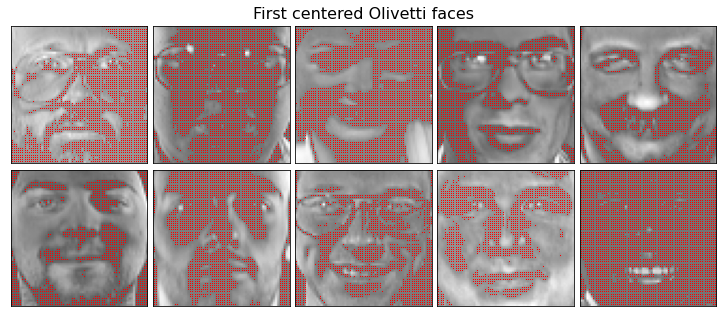

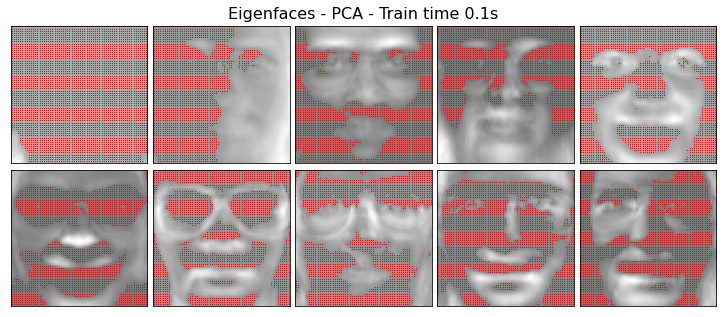

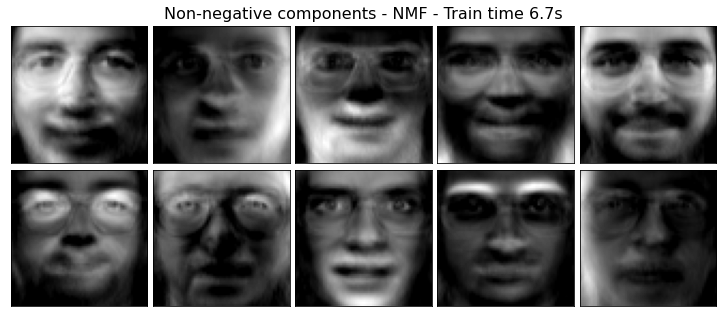

In [5]:
# pca_nmf_faces.py
# Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid
# License: BSD

from time import time
from numpy.random import RandomState
import pylab as pl
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition

# -- Prepare data and define utility functions ---------------------------------

n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)
print("Dataset consists of %d faces" % n_samples)

def plot_gallery(title, images):
    pl.figure(figsize=(2. * n_col, 2.26 * n_row))
    pl.suptitle(title, size=16)
    for i, comp in enumerate(images):
        pl.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0:
            yz, xz = dmy
        comp[comp<0] = 0
        pl.imshow(comp, cmap=pl.cm.gray, vmax=vmax, vmin=vmin)
    #print "vmax: %f, vmin: %f" % (vmax, vmin)
    #print comp
        if len(dmy[0])>0:
            pl.plot( xz, yz, 'r,')#hold=True)
            print(len(dmy[0]), "negative-valued pixels")
    
        pl.xticks(())
        pl.yticks(())
    
    pl.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# -- Decomposition methods -----

# List of the different estimators and whether to center the data
estimators = [('pca', 'Eigenfaces - PCA',
               decomposition.PCA(n_components=n_components, whiten=True),
               True),
              ('nmf', 'Non-negative components - NMF',
               decomposition.NMF(n_components=n_components, init=None, tol=1e-6,
                                 max_iter=2000),
               False)]

# -- Transform and classify ----------------------------------------------------

labels = dataset.target
X = faces
X_ = faces_centered
for shortname, name, estimator, center in estimators:
    #if shortname != 'nmf': continue
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = X
    if center:
        data = X_
    data = estimator.fit_transform(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
    components_[:n_components])

In [24]:
# pca_nmf_faces.py
# Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid
# License: BSD
from time import time
from numpy.random import RandomState
import pylab as pl
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter("ignore")
# -- Prepare data and define utility functions ---------------------------------

pca_scores = list()
nmf_scores = list()
pca_hax_scores = list()
nmf_hax_scores = list()
n_comps = range(10,52,10)

dataset = fetch_olivetti_faces(shuffle=True)
X = dataset.data
y = dataset.target
X_ = X - X.mean(axis=0, dtype=np.float64)

clf = LinearDiscriminantAnalysis()
for i in n_comps:
    pipe_PCA = Pipeline([('PCA', decomposition.PCA(n_components=i, whiten=True)), ('LDA', LinearDiscriminantAnalysis())])
    pipe_NMF = Pipeline([('NMF', decomposition.NMF(n_components=i, init='random', tol=1e-6, max_iter=200)), ('LDA', LinearDiscriminantAnalysis())])
    X_pca = decomposition.PCA(n_components=i, whiten=True).fit_transform(X_)
    X_nmf = decomposition.NMF(n_components=i, init='random', tol=1e-6, max_iter=200).fit_transform(X)
    cv_scores = cross_val_score(pipe_PCA, X_, y, cv=5)
    pca_scores.append(cv_scores.mean())
    cv_scores = cross_val_score(pipe_NMF, X, y, cv=5)
    nmf_scores.append(cv_scores.mean())
    cv_scores = cross_val_score(clf, X_pca, y, cv=5)
    pca_hax_scores.append(cv_scores.mean())
    cv_scores = cross_val_score(clf, X_nmf, y, cv=5)
    nmf_hax_scores.append(cv_scores.mean())

print("pour n_components =",i)
# LDA seule    
cv_scores = cross_val_score(clf, X_, y, cv=5)
print(f'score LDA seule: {cv_scores.mean():.2f} ± {2*cv_scores.std():.2f}')

# LDA après PCA
cv_scores = cross_val_score(pipe_PCA, X_, y, cv=5)
print(f'score LDA après PCA: {cv_scores.mean():.2f} ± {2*cv_scores.std():.2f}')

# LDA après NMF
cv_scores = cross_val_score(pipe_NMF, X, y, cv=5)
print(f'score LDA après NMF: {cv_scores.mean():.2f} ± {2*cv_scores.std():.2f}')

cv_scores = cross_val_score(clf, X_pca, y, cv=5)
print(f'score LDA après PCA triche: {cv_scores.mean():.2f} ± {2*cv_scores.std():.2f}')

# LDA après NMF
cv_scores = cross_val_score(clf, X_nmf, y, cv=5)
print(f'score LDA après NMF triche: {cv_scores.mean():.2f} ± {2*cv_scores.std():.2f}')

pour n_components = 50
score LDA seule: 0.98 ± 0.03
score LDA après PCA: 0.97 ± 0.03
score LDA après NMF: 0.97 ± 0.03
score LDA après PCA triche: 0.98 ± 0.03
score LDA après NMF triche: 0.97 ± 0.02


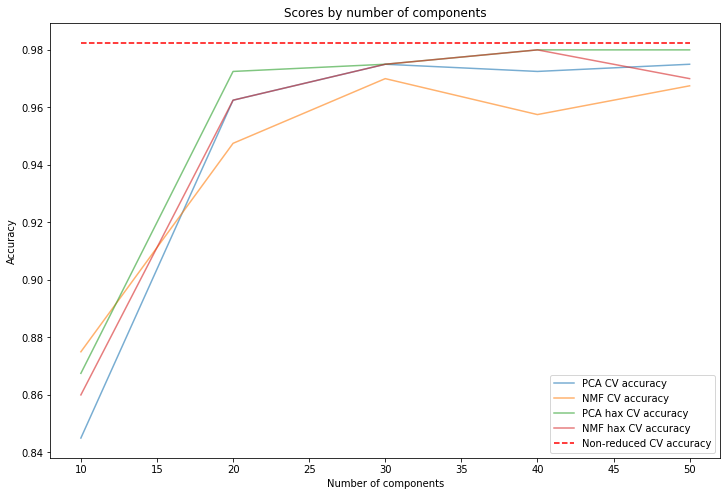

In [25]:
lda_nored = np.mean(cross_val_score(LinearDiscriminantAnalysis(),X,y))
a = .6

plt.figure(figsize=(12,8))
plt.plot(n_comps, pca_scores, label="PCA CV accuracy", alpha=a)
plt.plot(n_comps, nmf_scores, label="NMF CV accuracy", alpha=a)
plt.plot(n_comps, pca_hax_scores, label="PCA hax CV accuracy", alpha=a)
plt.plot(n_comps, nmf_hax_scores, label="NMF hax CV accuracy", alpha=a)
plt.plot(n_comps, [lda_nored for _ in n_comps], linestyle="dashed", color="red", label="Non-reduced CV accuracy")
plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Scores by number of components")
plt.show()

In [13]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: Simplified BSD
from time import time
from sklearn.feature_extraction import text
from sklearn import decomposition
from sklearn import datasets

n_samples = 100000
n_features = 100000
n_topics = 10
n_top_words = 10
# Load the 20 newsgroups dataset and vectorize it using the most common word
# frequency with TF-IDF weighting (without top 5% stop words)
t0 = time()
print("Loading dataset and extracting TF-IDF features...")
dataset = datasets.fetch_20newsgroups(shuffle=True, random_state=1)
vectorizer = text.TfidfVectorizer(max_df=.95, max_features=n_features, stop_words="english")
tfidf = vectorizer.fit_transform(dataset.data[:n_samples])
print("done in %0.3fs." % (time() - t0))
# Fit the NMF model
t0 = time()
print("Fitting the NMF model on with n_samples=%d and n_features=%d..." % (
n_samples, n_features))
nmf = decomposition.NMF(n_components=n_topics, init="random").fit(tfidf)
print("done in %0.3fs." % (time() - t0))
# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Loading dataset and extracting TF-IDF features...
done in 3.673s.
Fitting the NMF model on with n_samples=100000 and n_features=100000...
done in 9.700s.
Topic #0:
com gun people don writes car article netcom like just
Topic #1:
edu university host nntp posting ohio state cc cwru article
Topic #2:
god jesus bible people christian christians believe faith christ say
Topic #3:
nasa space gov henry jpl alaska toronto access ___ moon
Topic #4:
key clipper encryption chip escrow keys government algorithm security crypto
Topic #5:
pitt geb gordon banks cs cadre n3jxp dsl chastity shameful
Topic #6:
israel israeli jews armenian turkish armenians people arab armenia argic
Topic #7:
team ca game hockey players games year play season nhl
Topic #8:
windows scsi drive card dos file window use pc disk
Topic #9:
keith caltech livesey sgi morality wpd solntze objective cco jon
